## Declare functions

In [1]:
def modified_projection_M_gpu( wavefront,previous_wavefront,data ):
    fft    = cupy.fft.fftn( 2*wavefront-previous_wavefront ) 
    phi    = cupy.angle( fft )
    result = data * cupy.exp(1j * phi)
    
    diff =  numpy.abs(fft) - data 
    adiff = numpy.abs(diff)
    
    result[(data<0) | (adiff < 1)] =  fft[(data<0) | (adiff<1) ]
    
    tol = 1e-5 #jump@
    result[(data>=0) & (adiff >=1)] = fft[(data>=0) & (adiff>=1) ] * ( data[(data>=0) & (adiff>=1)] / ( numpy.maximum( numpy.abs(fft)[(data>=0) & (adiff>=1)] - diff[(data>=0) & (adiff>=1)]/ adiff[(data>=0) & (adiff>=1)], tol) ) )
    
    #TODO: MODIFY RESULT AS IN PAPER 
    
    result = cupy.fft.ifftn( result )- (wavefront-previous_wavefront)
    
    return result
    

def modulator_constraint(x,pinhole):
    # mean = np.mean(np.abs(x))
    # x = np.where(pinhole != 0,np.where(x>0,mean,0),0)
    # return x 
    return x*pinhole

def projection_S ( x, supp ):
    return x*supp
    
def ER(DP, wavefront, support):
    updated_wavefront = projection_M_gpu( wavefront, DP )
    wavefront = projection_S( updated_wavefront, support )
    return wavefront
    # return updated_wavefront
    
def HIO(DP, wavefront, support, support_complement,beta):
    updated_wavefront = projection_M_gpu( wavefront, DP )
    wavefront = projection_S( updated_wavefront, support ) + projection_S( wavefront - beta * updated_wavefront,  support_complement )         
    return wavefront
    # return updated_wavefront

def update_support(complex_obj,support):
    """ TODO: implement shrinkwrap update """
    return 0

def update_wavefront_to_upstream_of_modulator(original,auxiliary,current,previous,weight=1):
    updated = original + weight*auxiliary.conj()*(current-previous)/np.abs(np.max(auxiliary))**2
    return updated

def update_obj_and_probe(object,probe,wavefront,previous_wavefront,reg_obj=1,reg_probe=1):
    updated_object = object + reg_obj*probe.conj()*(wavefront-previous_wavefront)/np.abs(np.max(probe))**2
    updated_probe  = probe + reg_probe*object.conj()*(wavefront-previous_wavefront)/np.abs(np.max(object))**2
    return updated_object, updated_probe

def numpy_to_cupy(*args):
    output = []
    for arg in args:
        output.append(cupy.asarray(arg))
    if len(output)==1:
        return output[0]
    else:
        return output
    
def cupy_to_numpy(*args):
    output = []
    for arg in args:
        output.append(arg.get())
    if len(output)==1:
        return output[0]
    else:
        return output

def high_pass_filter_2D(img,cutoff):
    """ Cutoff value between 0 and ? """
    mask=np.zeros(img.shape)
    y,x = np.linspace(0,img.shape[0]-1,img.shape[0])-img.shape[0]//2,np.linspace(0,img.shape[1]-1,img.shape[1])-img.shape[1]//2
    Y,X = np.meshgrid(y,x)
    mask = np.where(X**2+Y**2<cutoff**2,0,1)
    FT = np.fft.fft2(img)
    filtered = mask*FT
    IFT = np.fft.ifft2(np.fft.fftshift(filtered))
    
    fig, ax = plt.subplots(1,3,dpi=250)
    ax1, ax2, ax3 = ax.ravel()
    ax1.imshow(mask)
    ax2.imshow(np.abs(FT),norm=LogNorm())
    ax3.imshow(mask*np.abs(FT),norm=LogNorm())
    
    return np.abs(IFT)
    
    
def get_support_from_AC(DP,threshold):
    """ Estimate support from auto-correlation """
    autocorr = np.fft.fftshift( np.fft.ifft2( DP ) )
    # autocorr = high_pass_filter_2D(autocorr,10)
    autocorr = np.abs(autocorr)
    
    autocorr -= np.min(autocorr)
    autocorr = autocorr/np.max(autocorr)
    
    support = np.where(autocorr>threshold*np.max(autocorr),1,0)
    return support, autocorr

def get_squared_support_from_AC(autocorrelation_threshold,delta):
    line, column = np.where(autocorrelation_threshold==np.max(autocorrelation_threshold))
    min_line, max_line = np.min(line), np.max(line)
    min_column, max_column = np.min(column), np.max(column)

    mean_column, mean_line = (max_column + min_column)//2, (max_line + min_line)//2
    thickness = max_column - min_column
    height = max_line - min_line

    # get half the AC mask as the support coordinates
    line_start, line_end = mean_line - height//4 - delta, mean_line + height//4 + delta # delta é um chorinho
    column_start, column_end = mean_column - thickness//4 - delta, mean_column + thickness//4 + delta
    
    support = np.zeros_like(autocorrelation_threshold)
    support[line_start:line_end,column_start:column_end] = 1
    return support

def get_modulator1(shape):
     return np.pi*np.random.randint(0,2,shape)

    
def propagation_fresnel(E0, z,energy,ps ):
    speed_of_light, planck = 299792458, 4.135667662E-18  # Plank constant [keV*s]; Speed of Light [m/s]

    # Parameters: E0 - initial complex field in x-y source plane
    #             ps - pixel size in microns
    #             lambda0 - wavelength in nm
    #             z - z-value (distance from sensor to object)
    #             background - optional background image to divide out from
    #                
    E0 = E0
    lambda0 = 1e9 * planck * speed_of_light / energy # nanometers
    ps = ps*1e6 #microns
    
    upsample_scale = 1;                 # Scale by which to upsample image
    n = upsample_scale * E0.shape[1] # Image width in pixels (same as height)
    grid_size = ps * n;                 # Grid size in x-direction
    

    # Inverse space
    fx = cp.linspace(-(n-1)/2*(1/grid_size), (n-1)/2*(1/grid_size), n)
    fy = cp.linspace(-(n-1)/2*(1/grid_size), (n-1)/2*(1/grid_size), n)
    Fx, Fy = cp.meshgrid(fx, fy)
    
    # Fresnel kernel / point spread function h = H(kx, ky)
    # from Fourier Optics, chapter 4
    # H = sqrt(z*lambda0)*exp(1i*pi*lambda0*z*(Fx.^2+Fy.^2)); 
    # sphere=exp(i*k/2/zc*(xx.^2+yy.^2));
    H = cp.exp(1j*(2 * cp.pi / lambda0) * z) * cp.exp(1j * cp.pi * lambda0 * z * (Fx**2 + Fy**2)) # (4.21)
    #H= cos(pi*lambda0*z*(Fx.^2+Fy.^2)+(2*pi*z)/lambda0)+1i.*sin(pi*lambda0*z*(Fx.^2+Fy.^2)+(2*pi*z)/lambda0);
    
    # Compute FFT centered about 0
    E0fft = FT((E0));     # Centered about 0 since fx and fy centered about 0
    
    # Multiply spectrum with fresnel phase-factor
    G = H * E0fft
    Ef = iFT(G) # Output after deshifting Fourier transform
    
    return Ef

### Main functions

In [21]:
speed_of_light, planck = 299792458, 4.135667662E-18  # Plank constant [keV*s]; Speed of Light [m/s]

def pwCDI(algo,iterations,DP,initial_guess,primary_inputs,shrinkwrap=False):
    """ Plane-wave CDI function

    Args:
        iterations (int): Total number of iterations_description_
        DP (numpy array): Diffraction pattern data
        initial_guess (numpy array): Initial guess for the object
        algo (string): Reconstruction algorithm to use. Options are: "ER", "HIO", ...
        primary_inputs (dict): Dictionary with the input parameters required by each different algorithm.
        
        primary_inputs = {  "support": np.ones((10,10)),
                            "distance": 2e-3,
                            "energy": 6,
                            "pixel_size: 20e-9,
                            "beta": 0.9,
                            "regularization_obj": 1,
                            "regularization_probe":1,
                            "modulator": np.ones((10,10))
                          }
    """    
    
    DP = np.sqrt(DP)
    DP, complex_obj = numpy_to_cupy(DP,initial_guess)
    
    """ Define secondary_inputs inputs """
    if algo == "ER":
        support = primary_inputs["support"]
    elif algo == "HIO": 
        support = primary_inputs["support"]
        beta  = primary_inputs["beta"] # change params to dictionary!
        support = cupy.asarray(support)
        support_complement = cupy.array( 1-support )
    elif algo == "CMI":
        support   = primary_inputs["support"]
        modulator = primary_inputs["modulator"]
        # modulator = support
        distance  = primary_inputs["distance"]
        energy    = primary_inputs["energy"]
        reg_obj   = primary_inputs["regularization_obj"]
        reg_probe = primary_inputs["regularization_probe"]
        beta      = primary_inputs["beta"]
        object_pixel_size = primary_inputs["pixel_size"]

        support = cupy.asarray(support)
        support_complement = cupy.array( 1-support )
        modulator = numpy_to_cupy(modulator)

        probe = numpy_to_cupy(propagation_fresnel(modulator,distance,energy,object_pixel_size))
        
        if beta != 0: 
            PR_algo = "HIO"
        else:
            PR_algo = "ER"
                    
        wavefront = complex_obj*probe
        
        if algo == "CMI":
            previous_wavefront_at_modulator_downstream, previous_wavefront_at_support = wavefront, wavefront
        
    for iteration in range(iterations):

        if iteration % 100 == 0: print("Iteration ",iteration)
        
        if shrinkwrap == True:
            support = update_support(complex_obj,support)
        
        if algo == "ER":
            complex_obj = ER(DP,complex_obj,support)
        elif algo == "HIO":
            complex_obj = HIO(DP,complex_obj,support,support_complement,beta)
        elif algo == "CMI":
            if distance > 0:
                wavefront, previous_wavefront_at_modulator_downstream, previous_wavefront_at_support, = modulated_phase_retrieval(DP, wavefront, previous_wavefront_at_modulator_downstream, previous_wavefront_at_support,modulator,distance,energy,object_pixel_size,support,support_complement,PR_algo,beta,reg_obj=reg_obj,reg_probe=reg_probe)
            else:
                wavefront, complex_obj, probe = pinhole_phase_retrieval(DP,complex_obj,probe, wavefront,modulator,distance,energy,object_pixel_size,support,support_complement,PR_algo,beta,reg_obj=reg_obj,reg_probe=reg_probe)
    
    if algo == "ER":
        complex_obj = cupy_to_numpy(complex_obj)
        # fig, ax = plt.subplots(1,2,dpi=150)
        # ax[0].imshow(np.angle(complex_obj)), ax[0].set_title("Phase")
        # ax[1].imshow(np.abs(complex_obj)),   ax[1].set_title("Abs")
        # for axis in ax.ravel(): axis.set_xticks([]), axis.set_yticks([])
        return complex_obj
    elif algo == "HIO":
        complex_obj = cupy_to_numpy(complex_obj)
        return complex_obj
    elif algo == "CMI":
        wavefront, complex_obj, probe = cupy_to_numpy(wavefront, complex_obj, probe)
        # fig, ax = plt.subplots(1,3,dpi=300)
        # ax[0].imshow(np.abs(wavefront)),   ax[0].set_title("Wavefront")
        # ax[1].imshow(np.abs(complex_obj)), ax[1].set_title("Complex Obj")
        # ax[2].imshow(np.abs(probe)),       ax[2].set_title("Probe")
        # for axis in ax.ravel(): axis.set_xticks([]), axis.set_yticks([])
        return wavefront


def modulated_phase_retrieval(DP, wavefront, previous_wavefront_at_modulator_downstream, previous_wavefront_at_support,modulator,distance,energy,object_pixel_size,support,support_complement,algo="ER",beta=0.9,reg_obj=1,reg_probe=1):

        if algo == "ER": # update wavefront using data
            wavefront_at_support = projection_S( wavefront, support )
        elif algo == "HIO":
            wavefront_at_support = projection_S( wavefront, support ) + projection_S( previous_wavefront_at_support - beta * wavefront,  support_complement )         
        previous_wavefront_at_support = wavefront_at_support.copy()
        
        wavefront_at_modulator_upstream = propagation_fresnel(wavefront_at_support,distance,energy,object_pixel_size) # propagate up to the object

        wavefront_at_modulator_downstream = modulator_constraint(wavefront_at_modulator_upstream,modulator)

        updated_wavefront_at_modulator_dowstream = modified_projection_M_gpu( wavefront_at_modulator_downstream, previous_wavefront_at_modulator_downstream, DP )
        previous_wavefront_at_modulator_downstream = wavefront_at_modulator_downstream.copy()
        
        previous_wavefront = updated_wavefront_at_modulator_dowstream.copy()

        updated_wavefront_at_modulator_upstream = update_wavefront_to_upstream_of_modulator(wavefront_at_modulator_upstream,modulator,updated_wavefront_at_modulator_dowstream,wavefront_at_modulator_downstream,weight=1)
        
        wavefront_at_support = propagation_fresnel(updated_wavefront_at_modulator_upstream,-distance,energy,object_pixel_size) # propagate up to the object

        return wavefront_at_support, previous_wavefront_at_modulator_downstream, previous_wavefront_at_support
        
def pinhole_phase_retrieval(DP,complex_object,probe, wavefront_at_support,modulator,distance,energy,object_pixel_size,support,support_complement,algo="ER",beta=0.9,reg_obj=1,reg_probe=1):        

     # modulator before sample
    probe = modulator_constraint(probe,modulator) # apply pinhole to sample

    probe = propagation_fresnel(probe,distance,energy,object_pixel_size) # propagate up to the object

    wavefront = probe*complex_object # multiple probe with object
    previous_wavefront = wavefront # save current wavefront

    if algo == "ER": # update wavefront using data
        wavefront = ER(DP, wavefront, support)
    elif algo == "HIO":
        wavefront = HIO(DP, wavefront, support, support_complement,beta)   

    probe = wavefront/complex_object # get new probe

    complex_object, probe = update_obj_and_probe(complex_object,probe,wavefront,previous_wavefront,reg_obj,reg_probe) # update function of the PIE family 

    probe = propagation_fresnel(probe,-distance,energy,object_pixel_size) # propagate back to the pinhole
        
    return wavefront, complex_object, probe


## Get phantom

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in log


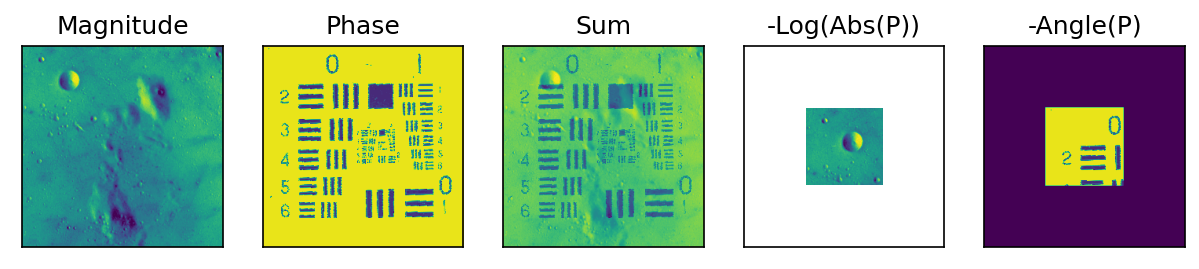

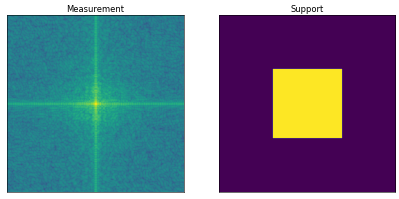

(None, None)

In [22]:
from PWCDI import *

speed_of_light, planck = 299792458, 4.135667662E-18  # Plank constant [keV*s]; Speed of Light [m/s]
N = 100

""" Input parameters """
distance = 28 # meters
energy = 6 # keV
wavelength = planck * speed_of_light / energy # metersw
wavevector = 2*np.pi/wavelength
detector_pixel = 55e-6 # meters
n_of_pixels = 3072 
object_pixel_size = get_object_pixel(n_of_pixels,detector_pixel,wavelength,distance)
distance_pinhole = 0.21e-3 # m
phase_retrieval_iterations = 300
reg_obj,reg_probe = 0.1, 0.2# PIE update function parameters
apply_support = True
beta = 0.9

""" Load phantom """
sample = 2
if sample==0: # Complex donut
    path = "/ibira/lnls/labs/tepui/proposals/20210062/yuri/yuri_ssc-cdi/00000000/data/ptycho3d/complex_phantom/"
    magnitude = np.load(os.path.join(path,'magnitude.npy'))
    phase = np.load(os.path.join(path,'magnitude.npy'))
    magnitude, phase = np.sum(phase,axis=0), np.sum(magnitude,axis=0)

    magnitude[0:magnitude.shape[0]//2,:] = 0
    phase[phase.shape[0]//2::,:]=0
    
    # P = 200
    # magnitude = np.pad(magnitude,((P,P),(P,P)))
    # phase = np.pad(phase,((P,P),(P,P)))
    
    # magnitude = np.roll(magnitude,(10,10))
    # phase = np.roll(phase,(-10,-10))
    phantom = np.exp(-magnitude)*np.exp(-1j*phase)
    
elif sample==1: # Célula
    phantom = np.load("ptychocell.npy")[0]
    magnitude = np.abs(phantom)
    phase = np.angle(phantom)
    phantom = np.squeeze(phantom)[300:1100,300:1100]

elif sample==2:
    from PIL import Image
    beta = np.array(Image.open('moon.tiff'))
    delta = np.array(Image.open('resolutionchart.tiff'))
    magnitude = 1*beta/np.max(beta)
    phase = 10*delta/np.max(delta)
    phantom = np.exp(-magnitude)*np.exp(-1j*phase)
    phantom = phantom[0:N,0:N]
    phantom = np.pad(phantom,(156//2,156//2))

threshold = 0.15

""" Load data """
DP = np.abs( np.fft.fftshift( np.fft.fft2(phantom) ) )**2 
np.save("complex_donuts_intensity.npy",DP)
object = np.ones_like(DP,dtype=complex)

if sample==0: #tight_support
    autocorrelation_threshold, autocorrelation = get_support_from_AC(DP,threshold)
    # support = get_squared_support_from_AC(autocorrelation_threshold,80)
    support = np.where(np.real(np.log(phantom)) != 0,1,0)
    N = phantom.shape[0]
    x = np.linspace(0,N-1,N) - N//2
    Y,X = np.meshgrid(x,x)
    support2 = np.where((X-0)**2+(Y-0)**2<50**2,1,0)
    # pinhole = np.where((X-0)**2+(Y-0)**2<200**2,1,0)
    support = support2+support
    support = np.where(support >= 1, 1,0)
if sample==1:
    N = phantom.shape[0]
    x = np.linspace(0,N-1,N) - N//2
    Y,X = np.meshgrid(x,x)
    support = np.where((X-10)**2+(Y-50)**2<180**2,1,0)
    
if sample == 2:
    support = np.where(np.abs(phantom)==0,0,1)
    N = phantom.shape[0]
    x = np.linspace(0,N-1,N) - N//2
    Y,X = np.meshgrid(x,x)
    pinhole = np.where((X-0)**2+(Y-0)**2<100**2,1,0)

half_support = support.copy()
half_support[0:support.shape[0],0:support.shape[1]//2] = 0
    
figure, ax = plt.subplots(1,5,dpi=150,figsize=(10,5))
ax1, ax2, ax3, ax4, ax5 = ax.ravel()
ax1.imshow(magnitude), ax1.set_title('Magnitude')
ax2.imshow(phase), ax2.set_title('Phase')
ax3.imshow(magnitude+phase), ax3.set_title('Sum')
ax4.imshow(-np.log(np.abs(phantom))), ax4.set_title("-Log(Abs(P))")
ax5.imshow(-np.angle(phantom)), ax5.set_title("-Angle(P)")
for axis in ax.ravel(): axis.set_xticks([]), axis.set_yticks([])
plt.show(), plt.close()

figure, ax = plt.subplots(1,2,dpi=50,figsize=(10,5))
ax1,ax4 = ax.ravel()
ax1.imshow(DP,norm=LogNorm()), ax1.set_title('Measurement')
ax4.imshow(support), ax4.set_title(f'Support')
for axis in ax.ravel(): axis.set_xticks([]), axis.set_yticks([])
plt.show(), plt.close()

## Call recon

Iteration  0
Iteration  100
Iteration  200
Iteration  300
Iteration  400
Iteration  500
Iteration  600
Iteration  700
Iteration  800
Iteration  900


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


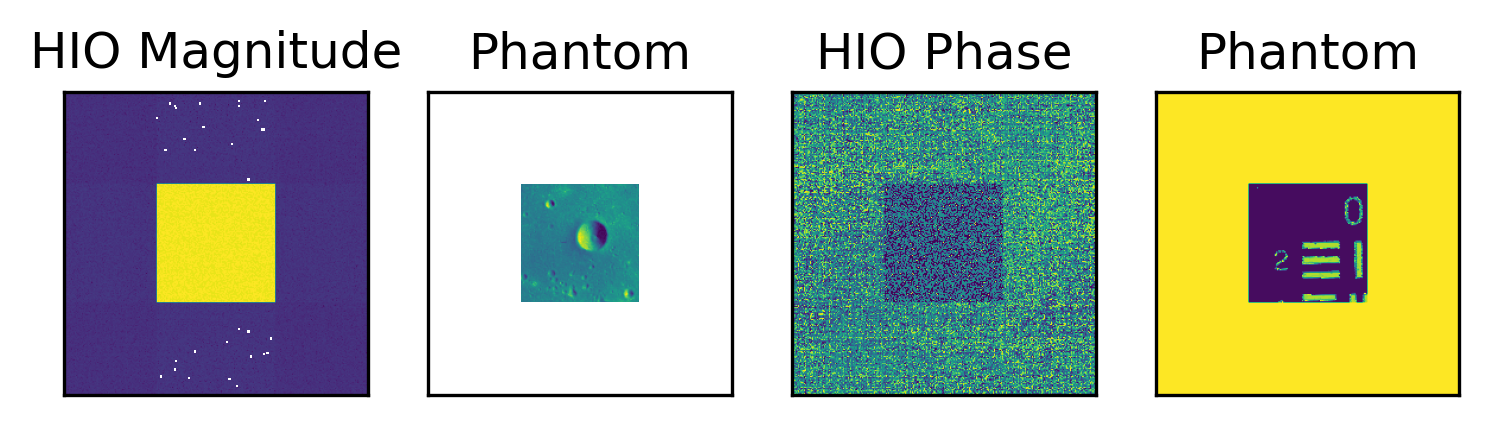

In [27]:
import cupy as cp
initial_guess = np.ones_like(support)

iterations1=20
iterations2=1000
iterations3=50

def plot(recon,phantom):
    fig, ax = plt.subplots(1,4,dpi=300)
    ax[0].imshow(np.log(np.abs(recon))),   ax[0].set_title("HIO Magnitude")
    ax[1].imshow(np.log(np.abs(phantom))), ax[1].set_title("Phantom")
    ax[2].imshow(np.angle(recon)), ax[2].set_title("HIO Phase")
    ax[3].imshow(np.angle(phantom)), ax[3].set_title("Phantom")
    for axis in ax.ravel(): axis.set_xticks([]), axis.set_yticks([])
    plt.show()

if 0: # benchmark
    primary_inputs = {  "support": cp.asarray(support),
                        "distance": -distance_pinhole,
                        "energy": energy,
                        "pixel_size": object_pixel_size,
                        "beta": 0.9,
                        "regularization_obj": 0,
                        "regularization_probe":0,
                        "modulator": np.ones_like(support)
                      }

    primary_inputs["support"] = cp.asarray(half_support)
    recon = np.squeeze(pwCDI("HIO",iterations1,DP,initial_guess,primary_inputs,shrinkwrap=False))

    plot(recon,phantom)
    
    primary_inputs["support"] = cp.asarray(support)
    recon = np.squeeze(pwCDI("HIO",iterations2,DP,recon,primary_inputs,shrinkwrap=False))

    plot(recon,phantom)
    
    recon = np.squeeze(pwCDI("ER",iterations3,DP,recon,primary_inputs,shrinkwrap=False))

    plot(recon,phantom)

elif 1: # modulator after sample

    primary_inputs = {  "support": support,
                        "distance": distance_pinhole,
                        "energy": energy,
                        "pixel_size": object_pixel_size,
                        "beta": 0.5,
                        "regularization_obj": 1,
                        "regularization_probe":1,
                        "modulator": np.exp(1j*get_modulator1(support.shape)),
                      }
    
    # primary_inputs["support"] = cp.asarray(half_support)
    # recon = np.squeeze(pwCDI("CMI",iterations1,DP,initial_guess,primary_inputs,shrinkwrap=False))
    # plot(recon,phantom)
    
    primary_inputs["support"] = cp.asarray(support)
    recon = np.squeeze(pwCDI("CMI",iterations2,DP,initial_guess,primary_inputs,shrinkwrap=False))
    plot(recon,phantom)

    
else: # modulator before sample
    primary_inputs = {  "support": support,
                        "distance": -distance_pinhole,
                        "energy": energy,
                        "pixel_size": object_pixel_size,
                        "beta": 0.9,
                        "regularization_obj": 0.9,
                        "regularization_probe":0.1,
                        "modulator": pinhole,#np.ones_like(support),
                      }
    
    primary_inputs["support"] = cp.asarray(half_support)
    recon = np.squeeze(pwCDI("CMI",iterations1,DP,initial_guess,primary_inputs,shrinkwrap=False))
    plot(recon,phantom)
    
    primary_inputs["support"] = cp.asarray(support)
    # primary_inputs["beta"] = 0
    recon = np.squeeze(pwCDI("CMI",iterations2,DP,recon,primary_inputs,shrinkwrap=False))
    plot(recon,phantom)
    
    primary_inputs["beta"] = 0
    recon = np.squeeze(pwCDI("CMI",iterations3,DP,recon,primary_inputs,shrinkwrap=False))
    plot(recon,phantom)
